In [ ]:
# PyTorch Dataset 심하 

> Dataset을 

In [1]:
import os 
import random
from collections import defaultdict
from typing import Tuple, List

In [2]:
from enum import Enum

In [3]:
from PIL import Image
from torch.utils.data import Dataset, Subset, random_split
from torchvision import transforms
from torchvision.transforms import *
import torch
import numpy as np

from torchsampler import ImbalancedDatasetSampler

In [4]:
IMG_EXTENSIONS = [
    ".jpg", ".JPG", ".jpeg", ".JPEG", ".png",
    ".PNG", ".ppm", ".PPM", ".bmp", ".BMP",
]


In [5]:
def is_image_file(filename):
    return any(filename.endswith(extension) for extension in IMG_EXTENSIONS)

In [6]:
class BaseAugmentation:
    def __init__(self, resize, mean, std, **args):
        self.transform = transforms.Compose([
            Resize(resize, Image.BILINEAR),
            ToTensor(),
            Normalize(mean=mean, std=std),
        ])

    def __call__(self, image):
        return self.transform(image)


In [7]:
class AddGaussianNoise(object):
    """
        transform 에 없는 기능들은 이런식으로 __init__, __call__, __repr__ 부분을
        직접 구현하여 사용할 수 있습니다.
    """

    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean

    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean

    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

In [ ]:
a = AddGaussianNoise()

In [ ]:
# def __repr__(self):
#    return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)
print(a)

In [8]:
class CustomAugmentation:
    def __init__(self, resize, mean, std, **args):
        self.transform = transforms.Compose([
            CenterCrop((320, 256)),
            Resize(resize, Image.BILINEAR),
            ColorJitter(0.1, 0.1, 0.1, 0.1),
            ToTensor(),
            Normalize(mean=mean, std=std),
            AddGaussianNoise()
        ])

    def __call__(self, image):
        return self.transform(image)

In [9]:
class MaskLabels(int, Enum):
    MASK = 0
    INCORRECT = 1
    NORMAL = 2

In [10]:
type(MaskLabels)

enum.EnumMeta

In [11]:
print(MaskLabels.MASK)
print(MaskLabels.INCORRECT)
MaskLabels.NORMAL

MaskLabels.MASK
MaskLabels.INCORRECT


<MaskLabels.NORMAL: 2>

In [12]:
for m in MaskLabels:
    print(m)

MaskLabels.MASK
MaskLabels.INCORRECT
MaskLabels.NORMAL


In [13]:
class GenderLabels(int, Enum):
    MALE = 0
    FEMALE = 1

    @classmethod
    def from_str(cls, value: str) -> int:
        value = value.lower()
        if value == "male":
            return cls.MALE
        elif value == "female":
            return cls.FEMALE
        else:
            raise ValueError(f"Gender value should be either 'male' or 'female', {value}")


In [14]:
class AgeLabels(int, Enum):
    YOUNG = 0
    MIDDLE = 1
    OLD = 2

    @classmethod
    def from_number(cls, value: str) -> int:
        try:
            value = int(value)
        except Exception:
            raise ValueError(f"Age value should be numeric, {value}")

        if value < 30:
            return cls.YOUNG
        elif value < 60:
            return cls.MIDDLE
        else:
            return cls.OLD

GenderLabels.from_str('male')

In [15]:
class MaskBaseDataset(Dataset):
    num_classes = 3 * 2 * 3

    _file_names = {
        "mask1": MaskLabels.MASK,
        "mask2": MaskLabels.MASK,
        "mask3": MaskLabels.MASK,
        "mask4": MaskLabels.MASK,
        "mask5": MaskLabels.MASK,
        "incorrect_mask": MaskLabels.INCORRECT,
        "normal": MaskLabels.NORMAL
    }

    image_paths = []
    mask_labels = []
    gender_labels = []
    age_labels = []

    def __init__(self, data_dir, mean=(0.548, 0.504, 0.479), std=(0.237, 0.247, 0.246), val_ratio=0.2):
        self.data_dir = data_dir
        self.mean = mean
        self.std = std
        self.val_ratio = val_ratio

        self.transform = None
        self.setup()
        self.calc_statistics()

    def setup(self):
        profiles = os.listdir(self.data_dir)
        for profile in profiles:
            if profile.startswith("."):  # "." 로 시작하는 파일은 무시합니다
                continue

            img_folder = os.path.join(self.data_dir, profile)
            for file_name in os.listdir(img_folder):
                _file_name, ext = os.path.splitext(file_name)
                if _file_name not in self._file_names:  # "." 로 시작하는 파일 및 invalid 한 파일들은 무시합니다
                    continue

                img_path = os.path.join(self.data_dir, profile, file_name)  # (resized_data, 000004_male_Asian_54, mask1.jpg)
                mask_label = self._file_names[_file_name]

                id, gender, race, age = profile.split("_")
                gender_label = GenderLabels.from_str(gender)
                age_label = AgeLabels.from_number(age)

                self.image_paths.append(img_path)
                self.mask_labels.append(mask_label)
                self.gender_labels.append(gender_label)
                self.age_labels.append(age_label)

    def calc_statistics(self):
        has_statistics = self.mean is not None and self.std is not None
        if not has_statistics:
            print("[Warning] Calculating statistics... It can take a long time depending on your CPU machine")
            sums = []
            squared = []
            for image_path in self.image_paths[:3000]:
                image = np.array(Image.open(image_path)).astype(np.int32)
                sums.append(image.mean(axis=(0, 1)))
                squared.append((image ** 2).mean(axis=(0, 1)))

            self.mean = np.mean(sums, axis=0) / 255
            self.std = (np.mean(squared, axis=0) - self.mean ** 2) ** 0.5 / 255

    def set_transform(self, transform):
        self.transform = transform

    def __getitem__(self, index):
        assert self.transform is not None, ".set_tranform 메소드를 이용하여 transform 을 주입해주세요"

        image = self.read_image(index)
        mask_label = self.get_mask_label(index)
        gender_label = self.get_gender_label(index)
        age_label = self.get_age_label(index)
        multi_class_label = self.encode_multi_class(mask_label, gender_label, age_label)

        image_transform = self.transform(image)
        return image_transform, multi_class_label

    def __len__(self):
        return len(self.image_paths)

    def get_mask_label(self, index) -> MaskLabels:
        return self.mask_labels[index]

    def get_gender_label(self, index) -> GenderLabels:
        return self.gender_labels[index]

    def get_age_label(self, index) -> AgeLabels:
        return self.age_labels[index]

    def read_image(self, index):
        image_path = self.image_paths[index]
        return Image.open(image_path)

    @staticmethod
    def encode_multi_class(mask_label, gender_label, age_label) -> int:
        return mask_label * 6 + gender_label * 3 + age_label

    @staticmethod
    def decode_multi_class(multi_class_label) -> Tuple[MaskLabels, GenderLabels, AgeLabels]:
        mask_label = (multi_class_label // 6) % 3
        gender_label = (multi_class_label // 3) % 2
        age_label = multi_class_label % 3
        return mask_label, gender_label, age_label

    @staticmethod
    def denormalize_image(image, mean, std):
        img_cp = image.copy()
        img_cp *= std
        img_cp += mean
        img_cp *= 255.0
        img_cp = np.clip(img_cp, 0, 255).astype(np.uint8)
        return img_cp

    def split_dataset(self) -> Tuple[Subset, Subset]:
        """
        데이터셋을 train 과 val 로 나눕니다,
        pytorch 내부의 torch.utils.data.random_split 함수를 사용하여
        torch.utils.data.Subset 클래스 둘로 나눕니다.
        구현이 어렵지 않으니 구글링 혹은 IDE (e.g. pycharm) 의 navigation 기능을 통해 코드를 한 번 읽어보는 것을 추천드립니다^^
        """
        n_val = int(len(self) * self.val_ratio)
        n_train = len(self) - n_val
        train_set, val_set = random_split(self, [n_train, n_val])
        return train_set, val_set

In [ ]:
data_dir = '/opt/ml/input/data/train/images'
profiles = os.listdir(data_dir)
# print(profiles)

def encode_multi_class(mask_label, gender_label, age_label) -> int:
    return mask_label * 6 + gender_label * 3 + age_label

_file_names = {
        "mask1": MaskLabels.MASK,
        "mask2": MaskLabels.MASK,
        "mask3": MaskLabels.MASK,
        "mask4": MaskLabels.MASK,
        "mask5": MaskLabels.MASK,
        "incorrect_mask": MaskLabels.INCORRECT,
        "normal": MaskLabels.NORMAL
}
image_paths = []
mask_labels = []
gender_labels = []
age_labels = []

multi_label_dict = defaultdict(list)

cnt = 0
for profile in profiles:
    if profile.startswith("."):  # "." 로 시작하는 파일은 무시합니다
        continue

    img_folder = os.path.join(data_dir, profile)

    for file_name in os.listdir(img_folder):
        _file_name, ext = os.path.splitext(file_name)
        if _file_name not in _file_names:  # "." 로 시작하는 파일 및 invalid 한 파일들은 무시합니다
            continue
        img_path = os.path.join(data_dir, profile, file_name)
        mask_label = _file_names[_file_name]

        id, gender, race, age = profile.split("_")
        gender_label = GenderLabels.from_str(gender)
        age_label = AgeLabels.from_number(age)

        image_paths.append(img_path)
        mask_labels.append(mask_label)
        gender_labels.append(gender_label)
        age_labels.append(age_label)
        multi_class_label = encode_multi_class(mask_label, gender_label, age_label)
        multi_label_dict[multi_class_label].append(cnt)
        cnt += 1

In [ ]:
for key, value in multi_label_dict.items():
    print(f'key : {key}, len(value) : {len(value)}')

In [ ]:
train_indices = []
val_indices = []
        
for key, value in multi_label_dict.items():
    n_val = int(len(value) * 0.2)
    random.shuffle(value)
    key_val_indices = value[:n_val]
    key_train_indices = value[n_val:]
    
    train_indices.append(key_train_indices)
    val_indices.append(key_val_indices)
    

In [ ]:
print(len(set(train_indices) |set(val_indices)))

In [ ]:
print()

In [ ]:
from pprint import pprint
for key, value in multi_label_dict.items():
    print(f'{key} : {len(value)}')


In [16]:
class MaskStratifiedDataset(Dataset):
    num_classes = 3 * 2 * 3

    _file_names = {
        "mask1": MaskLabels.MASK,
        "mask2": MaskLabels.MASK,
        "mask3": MaskLabels.MASK,
        "mask4": MaskLabels.MASK,
        "mask5": MaskLabels.MASK,
        "incorrect_mask": MaskLabels.INCORRECT,
        "normal": MaskLabels.NORMAL
    }
    multi_label_dict = defaultdict(list)
    image_paths = []
    mask_labels = []
    gender_labels = []
    age_labels = []

    def __init__(self, data_dir, mean=(0.548, 0.504, 0.479), std=(0.237, 0.247, 0.246), val_ratio=0.2):
        self.data_dir = data_dir
        self.mean = mean
        self.std = std
        self.val_ratio = val_ratio

        self.transform = None
        self.setup()
        self.calc_statistics()

    def setup(self):
        profiles = os.listdir(self.data_dir)
        indice = 0
        for profile in profiles:
            if profile.startswith("."):  # "." 로 시작하는 파일은 무시합니다
                continue

            img_folder = os.path.join(self.data_dir, profile)
            for file_name in os.listdir(img_folder):
                _file_name, ext = os.path.splitext(file_name)
                if _file_name not in self._file_names:  # "." 로 시작하는 파일 및 invalid 한 파일들은 무시합니다
                    continue

                img_path = os.path.join(self.data_dir, profile, file_name)  # (resized_data, 000004_male_Asian_54, mask1.jpg)
                mask_label = self._file_names[_file_name]

                id, gender, race, age = profile.split("_")
                gender_label = GenderLabels.from_str(gender)
                age_label = AgeLabels.from_number(age)

                self.image_paths.append(img_path)
                self.mask_labels.append(mask_label)
                self.gender_labels.append(gender_label)
                self.age_labels.append(age_label)
                
                multi_class_label = self.encode_multi_class(mask_label, gender_label, age_label)
                self.multi_label_dict[multi_class_label].append(indice)
                indice += 1

    def calc_statistics(self):
        has_statistics = self.mean is not None and self.std is not None
        if not has_statistics:
            print("[Warning] Calculating statistics... It can take a long time depending on your CPU machine")
            sums = []
            squared = []
            for image_path in self.image_paths[:3000]:
                image = np.array(Image.open(image_path)).astype(np.int32)
                sums.append(image.mean(axis=(0, 1)))
                squared.append((image ** 2).mean(axis=(0, 1)))

            self.mean = np.mean(sums, axis=0) / 255
            self.std = (np.mean(squared, axis=0) - self.mean ** 2) ** 0.5 / 255

    def set_transform(self, transform):
        self.transform = transform

    def __getitem__(self, index):
        assert self.transform is not None, ".set_tranform 메소드를 이용하여 transform 을 주입해주세요"

        image = self.read_image(index)
        mask_label = self.get_mask_label(index)
        gender_label = self.get_gender_label(index)
        age_label = self.get_age_label(index)
        multi_class_label = self.encode_multi_class(mask_label, gender_label, age_label)

        image_transform = self.transform(image)
        return image_transform, multi_class_label

    def __len__(self):
        return len(self.image_paths)

    def get_mask_label(self, index) -> MaskLabels:
        return self.mask_labels[index]

    def get_gender_label(self, index) -> GenderLabels:
        return self.gender_labels[index]

    def get_age_label(self, index) -> AgeLabels:
        return self.age_labels[index]

    def read_image(self, index):
        image_path = self.image_paths[index]
        return Image.open(image_path)

    @staticmethod
    def encode_multi_class(mask_label, gender_label, age_label) -> int:
        return mask_label * 6 + gender_label * 3 + age_label

    @staticmethod
    def decode_multi_class(multi_class_label) -> Tuple[MaskLabels, GenderLabels, AgeLabels]:
        mask_label = (multi_class_label // 6) % 3
        gender_label = (multi_class_label // 3) % 2
        age_label = multi_class_label % 3
        return mask_label, gender_label, age_label

    @staticmethod
    def denormalize_image(image, mean, std):
        img_cp = image.copy()
        img_cp *= std
        img_cp += mean
        img_cp *= 255.0
        img_cp = np.clip(img_cp, 0, 255).astype(np.uint8)
        return img_cp

    def split_dataset(self) -> Tuple[Subset, Subset]:
        """
        데이터셋을 train 과 val 로 나눕니다,
        pytorch 내부의 torch.utils.data.random_split 함수를 사용하여
        torch.utils.data.Subset 클래스 둘로 나눕니다.
        구현이 어렵지 않으니 구글링 혹은 IDE (e.g. pycharm) 의 navigation 기능을 통해 코드를 한 번 읽어보는 것을 추천드립니다^^
        """
        train_indices = []
        val_indices = []

        for key, value in self.multi_label_dict.items():
            n_val = int(len(value) * 0.2)
            random.shuffle(value)
            key_val_indices = value[:n_val]
            key_train_indices = value[n_val:]

            val_indices += key_val_indices
            train_indices += key_train_indices
            
            random.shuffle(val_indices)
            random.shuffle(train_indices)
            
        return Subset(self, train_indices), Subset(self, val_indices)

In [17]:
class MaskStratifiedDataset(MaskBaseDataset):
    """
        target class에 proportional 하게 train/val set을 나눔
    """
    def __init__(self, data_dir, mean=(0.548, 0.504, 0.479), std=(0.237, 0.247, 0.246), val_ratio=0.2):
        self.multi_label_dict = defaultdict(list)
        super().__init__(data_dir, mean, std, val_ratio)

    def setup(self):
        profiles = os.listdir(self.data_dir)
        indice = 0
        for profile in profiles:
            if profile.startswith("."):  # "." 로 시작하는 파일은 무시합니다
                continue

            img_folder = os.path.join(self.data_dir, profile)
            for file_name in os.listdir(img_folder):
                _file_name, ext = os.path.splitext(file_name)
                if _file_name not in self._file_names:  # "." 로 시작하는 파일 및 invalid 한 파일들은 무시합니다
                    continue

                img_path = os.path.join(self.data_dir, profile, file_name)  # (resized_data, 000004_male_Asian_54, mask1.jpg)
                mask_label = self._file_names[_file_name]

                id, gender, race, age = profile.split("_")
                gender_label = GenderLabels.from_str(gender)
                age_label = AgeLabels.from_number(age)

                self.image_paths.append(img_path)
                self.mask_labels.append(mask_label)
                self.gender_labels.append(gender_label)
                self.age_labels.append(age_label)
                
                multi_class_label = self.encode_multi_class(mask_label, gender_label, age_label)
                self.multi_label_dict[multi_class_label].append(indice)
                indice += 1

    def split_dataset(self) -> Tuple[Subset, Subset]:
        train_indices = []
        val_indices = []

        for key, value in self.multi_label_dict.items():
            n_val = int(len(value) * self.val_ratio)
            random.shuffle(value)
            key_val_indices = value[:n_val]
            key_train_indices = value[n_val:]

            val_indices += key_val_indices
            train_indices += key_train_indices
            
            random.shuffle(val_indices)
            random.shuffle(train_indices)
            
        return Subset(self, train_indices), Subset(self, val_indices)

In [18]:
class BaseAugmentation:
    def __init__(self, resize, mean, std, **args):
        self.transform = transforms.Compose([
            Resize(resize, Image.BILINEAR),
            ToTensor(),
            Normalize(mean=mean, std=std),
        ])

    def __call__(self, image):
        return self.transform(image)

In [ ]:
dataset = MaskStratifiedDataset('/opt/ml/input/data/train/images')
dataset.num_classes

In [ ]:
transform = BaseAugmentation(
        resize=[224,224],
        mean=dataset.mean,
        std=dataset.std,
    )
dataset.set_transform(transform)

In [ ]:
train_set, val_set = dataset.split_dataset()

In [ ]:
len(train_set), len(val_set)

In [ ]:
train_loader = DataLoader(
        train_set,
        batch_size=2,
        shuffle=True,
        drop_last=True,
    )

In [ ]:
a = next(iter(train_loader))

In [ ]:
for train_batch in train_loader:
    inputs, labels = train_batch
    break


In [ ]:
labels

In [ ]:
train_dist = defaultdict(lambda:0)
for i, x in enumerate(train_data):
    train_dist[x[1]] += 1

In [ ]:
val_dist = defaultdict(lambda:0)
for i, x in enumerate(val_data):
    val_dist[x[1]] += 1

In [ ]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(15, 7))
axes[0].bar(train_dist.keys(), train_dist.values(), color='royalblue')
axes[1].bar(val_dist.keys(), val_dist.values(), color='tomato')
    
plt.show()

In [19]:
class ThreeWayStratifiedDataset(MaskBaseDataset):
    def __init__(self, data_dir, mean=(0.548, 0.504, 0.479), std=(0.237, 0.247, 0.246), val_ratio=0.2):
        self.multi_label_dict = defaultdict(list)
        super().__init__(data_dir, mean, std, val_ratio)
    
    def __getitem__(self, index):
        assert self.transform is not None, ".set_tranform 메소드를 이용하여 transform 을 주입해주세요"

        image = self.read_image(index)
        mask_label = self.get_mask_label(index)
        gender_label = self.get_gender_label(index)
        age_label = self.get_age_label(index)
        multi_class_label = self.encode_multi_class(mask_label, gender_label, age_label)

        image_transform = self.transform(image)
        return image_transform, [age_label, mask_label, gender_label]
    
    def setup(self):
        profiles = os.listdir(self.data_dir)
        indice = 0
        for profile in profiles:
            if profile.startswith("."):  # "." 로 시작하는 파일은 무시합니다
                continue

            img_folder = os.path.join(self.data_dir, profile)
            for file_name in os.listdir(img_folder):
                _file_name, ext = os.path.splitext(file_name)
                if _file_name not in self._file_names:  # "." 로 시작하는 파일 및 invalid 한 파일들은 무시합니다
                    continue

                img_path = os.path.join(self.data_dir, profile, file_name)  # (resized_data, 000004_male_Asian_54, mask1.jpg)
                mask_label = self._file_names[_file_name]

                gender, race, age = profile.split("_")
                gender_label = GenderLabels.from_str(gender)
                age_label = AgeLabels.from_number(age)

                self.image_paths.append(img_path)
                self.mask_labels.append(mask_label)
                self.gender_labels.append(gender_label)
                self.age_labels.append(age_label)
                
                multi_class_label = self.encode_multi_class(mask_label, gender_label, age_label)
                self.multi_label_dict[multi_class_label].append(indice)
                indice += 1

    def split_dataset(self) -> Tuple[Subset, Subset]:
        """
        데이터셋을 target 의 비율로 나눕니다.
        """
        train_indices = []
        val_indices = []

        for key, value in self.multi_label_dict.items():
            n_val = int(len(value) * self.val_ratio)
            random.shuffle(value)
            key_val_indices = value[:n_val]
            key_train_indices = value[n_val:]

            val_indices += key_val_indices
            train_indices += key_train_indices
            
            random.shuffle(val_indices)
            random.shuffle(train_indices)
            
        return Subset(self, train_indices), Subset(self, val_indices)

In [ ]:
dataset = ThreeWayStratifiedDataset('/opt/ml/input/data/train/images')
dataset.num_classes

In [ ]:
transform = BaseAugmentation(
        resize=[224,224],
        mean=dataset.mean,
        std=dataset.std,
    )
dataset.set_transform(transform)

In [ ]:
train_set, val_set = dataset.split_dataset()

In [ ]:
len(train_set), len(val_set)

In [ ]:
train_loader = DataLoader(
        train_set,
        batch_size=5,
        shuffle=True,
        drop_last=True,
    )

In [ ]:
for train_batch in train_loader:
    inputs, labels = train_batch
    break

In [ ]:
inputs, labels

In [ ]:
def collate_fn(batch):
    
    data_list, label_list = [], []
    
    for _data, _label in batch:
        data_list.append(_data)
        label_list.append(torch.LongTensor(_label))
    data_list = torch.stack(data_list, dim = 0)
    label_list = torch.stack(label_list, dim = 1)
    
    return torch.Tensor(data_list), label_list

In [ ]:
train_loader2 = DataLoader(
        train_set,
        batch_size=5,
        collate_fn=collate_fn,
        shuffle=True,
        drop_last=True,
    )

In [ ]:
import torch
for train_batch in train_loader2:
    inputs, labels = train_batch
    break

In [ ]:
type(inputs), type(labels)

In [ ]:
inputs.shape

In [ ]:
labels.shape

In [ ]:
labels

In [ ]:
labels[0,:]

## Custom

In [20]:
class MaskSplitByProfileDataset(MaskBaseDataset):
    """
        train / val 나누는 기준을 이미지에 대해서 random 이 아닌
        사람(profile)을 기준으로 나눕니다.
        구현은 val_ratio 에 맞게 train / val 나누는 것을 이미지 전체가 아닌 사람(profile)에 대해서 진행하여 indexing 을 합니다
        이후 `split_dataset` 에서 index 에 맞게 Subset 으로 dataset 을 분기합니다.
    """

    def __init__(self, data_dir, mean=(0.548, 0.504, 0.479), std=(0.237, 0.247, 0.246), val_ratio=0.2):
        self.indices = defaultdict(list)
        super().__init__(data_dir, mean, std, val_ratio)

    @staticmethod
    def _split_profile(profiles, val_ratio):
        length = len(profiles)
        n_val = int(length * val_ratio)

        val_indices = set(random.choices(range(length), k=n_val))
        train_indices = set(range(length)) - val_indices
        return {
            "train": train_indices,
            "val": val_indices
        }

    def setup(self):
        profiles = os.listdir(self.data_dir)
        profiles = [profile for profile in profiles if not profile.startswith(".")]
        split_profiles = self._split_profile(profiles, self.val_ratio)

        cnt = 0
        for phase, indices in split_profiles.items():
            for _idx in indices:
                profile = profiles[_idx]
                img_folder = os.path.join(self.data_dir, profile)
                for file_name in os.listdir(img_folder):
                    _file_name, ext = os.path.splitext(file_name)
                    if _file_name not in self._file_names:  # "." 로 시작하는 파일 및 invalid 한 파일들은 무시합니다
                        continue

                    img_path = os.path.join(self.data_dir, profile, file_name)  # (resized_data, 000004_male_Asian_54, mask1.jpg)
                    mask_label = self._file_names[_file_name]

                    id, gender, race, age = profile.split("_")
                    gender_label = GenderLabels.from_str(gender)
                    age_label = AgeLabels.from_number(age)

                    self.image_paths.append(img_path)
                    self.mask_labels.append(mask_label)
                    self.gender_labels.append(gender_label)
                    self.age_labels.append(age_label)

                    self.indices[phase].append(cnt)
                    cnt += 1

    def split_dataset(self) -> List[Subset]:
        return [Subset(self, indices) for phase, indices in self.indices.items()]

In [21]:
class OnlyAgeMaskSplitByProfileDataset(MaskSplitByProfileDataset):
    """
        train / val 나누는 기준을 이미지에 대해서 random 이 아닌
        사람(profile)을 기준으로 나눕니다.
        구현은 val_ratio 에 맞게 train / val 나누는 것을 이미지 전체가 아닌 사람(profile)에 대해서 진행하여 indexing 을 합니다
        이후 `split_dataset` 에서 index 에 맞게 Subset 으로 dataset 을 분기합니다.
    """

    def __init__(self, data_dir, mean=(0.548, 0.504, 0.479), std=(0.237, 0.247, 0.246), val_ratio=0.2):
        super().__init__(data_dir, mean, std, val_ratio)
        self.num_classes = 3
    
    def __getitem__(self, index):
        assert self.transform is not None, ".set_tranform 메소드를 이용하여 transform 을 주입해주세요"
        
        image = self.read_image(index)
        age_label = self.get_age_label(index)
        image_transform = self.transform(image)
        
        return image_transform, age_label

In [22]:
class BasicAugmentation2:
    def __init__(self, resize, mean, std, **args):
        self.transform = transforms.Compose([
            CenterCrop((384, int(384*0.8))),
            Resize(resize, Image.BILINEAR),
            ToTensor(),
            Normalize(mean=mean, std=std),
        ])

    def __call__(self, image):
        return self.transform(image)

In [23]:
data_dir = '/opt/ml/input/data/train/images'

dataset = OnlyAgeMaskSplitByProfileDataset(
    data_dir=data_dir,
)
num_classes = dataset.num_classes

In [24]:
print(num_classes)

3


In [25]:
# default: BaseAugmentation
transform = BasicAugmentation2(
    resize=[224,224],
    mean=dataset.mean,
    std=dataset.std,
)
dataset.set_transform(transform)

In [35]:
lst = []
i = 0

for image, label in dataset:
#     lst.append((image.numpy()[0], label)
    i = i + 1
    if i == 3:
        break
    

In [51]:
iter_d = iter(dataset)

In [81]:
image, label = next(iter_d)

In [82]:
label

<AgeLabels.OLD: 2>

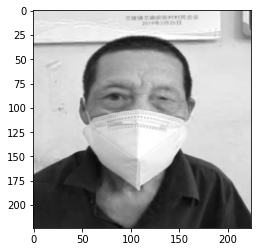

In [83]:
import matplotlib.pyplot as plt

plt.imshow(image.numpy()[0], cmap='gray')

In [ ]:
def grid_image(np_images, gts, preds, n=16, shuffle=False):
    batch_size = np_images.shape[0]
    assert n <= batch_size

    choices = random.choices(range(batch_size), k=n) if shuffle else list(range(n))
    figure = plt.figure(figsize=(12, 18 + 2))  # cautions: hardcoded, 이미지 크기에 따라 figsize 를 조정해야 할 수 있습니다. T.T
    plt.subplots_adjust(top=0.8)               # cautions: hardcoded, 이미지 크기에 따라 top 를 조정해야 할 수 있습니다. T.T
    n_grid = np.ceil(n ** 0.5)
    tasks = ["mask", "gender", "age"]
    for idx, choice in enumerate(choices):
        gt = gts[choice].item()
        pred = preds[choice].item()
        image = np_images[choice]
        # title = f"gt: {gt}, pred: {pred}"
        gt_decoded_labels = MaskBaseDataset.decode_multi_class(gt)
        pred_decoded_labels = MaskBaseDataset.decode_multi_class(pred)
        title = "\n".join([
            f"{task} - gt: {gt_label}, pred: {pred_label}"
            for gt_label, pred_label, task
            in zip(gt_decoded_labels, pred_decoded_labels, tasks)
        ])

        plt.subplot(n_grid, n_grid, idx + 1, title=title)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(image, cmap=plt.cm.binary)

    return figure